# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [3]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1546k  100 1546k    0     0   550k      0  0:00:02  0:00:02 --:--:-- 1081k


In [4]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  385k  100  385k    0     0   183k      0  0:00:02  0:00:02 --:--:--  472k


In [5]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  230k  100  230k    0     0  97472      0  0:00:02  0:00:02 --:--:--  202k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [1]:
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.2/225.2 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musical    

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

,title
movieid,
5,Copycat (1995)
4,Get Shorty (1995)
1,Toy Story (1995)


**Paso 4:** Generemos algunos gráficos en relación a las películas.

<ipython-input-12-0b4dfa6fddf0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")


<Axes: ylabel='None'>

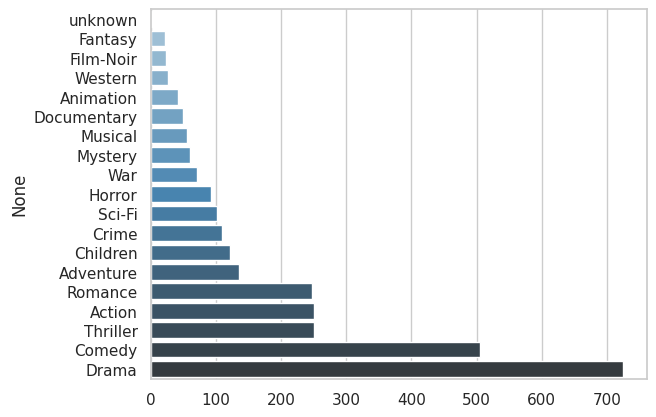

In [12]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

**Paso 5 (2ptos):** Explique cómo funciona SVD (como modelo, no piense en la implementación).





**Respuesta:** *COMPLETAR*

## SVD

**Paso 6**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [13]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [14]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [15]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7206927783798065
RMSE: 0.9143021068489765


In [16]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.12325373396194841
NDCG@20: 0.0663944440583718


In [17]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1449, 169, 1512, 1398, 408, 1367, 480, 483, 1467, 1639, 318, 511, 1536, 189, 1500, 12, 134, 119, 1064, 113]


In [18]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1398,Anna (1996),13-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Anna%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
480,North by Northwest (1959),01-Jan-1959,NaN,http://us.imdb.com/M/title-exact?North%20by%20...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Paso 7 (10ptos):** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores (n_factors)
- Número de iteraciones máxima (n_epochs)
- Learning rate (lr_all)

Y hay muchos más que pueden probar.

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió (2 ptos por cada combinación probada y comentada): *COMPLETAR*

**Paso 8:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [19]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)

  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)

  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7202592481331549, 0.7207977927596355, 0.7201433128226451]
[0.9140634590517979, 0.9140047206642546, 0.9130356827226673]


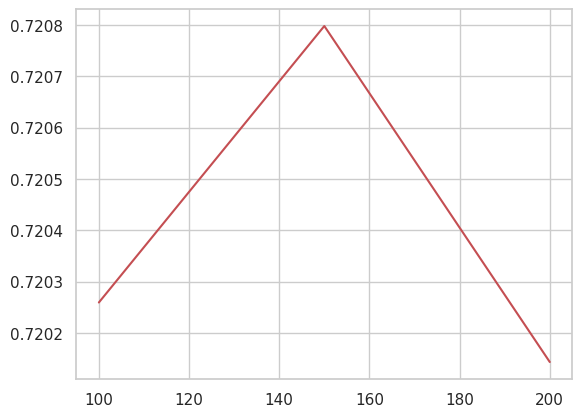

In [20]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

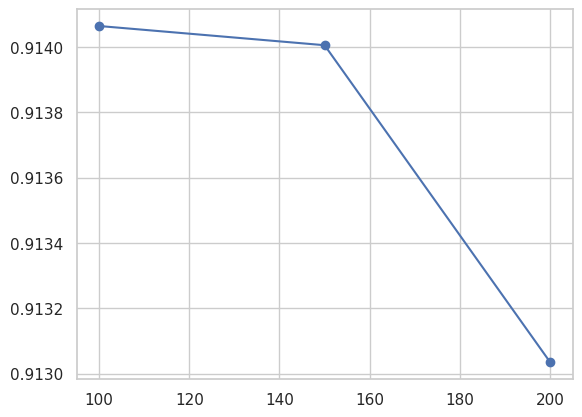

In [21]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 9 (6 ptos):** Pruebe con otros valores y/o parámetros (mínimo 3 combinaciones. Se recomienda elegir entre las combinaciones del paso 7):

*COMPLETAR*